# Similitud de Texto II: 
# One-Hot Encoding + Modelo de Regresión Secuencial con Atención 

## Índice:
1. Modelo de regresión con atención
2. One-Hot Encoding
3. Experimentación con embeddings
    - Embeddings aleatorios
    - Diferentes dimensiones de embeddings
4. Modelos avanzados
    - Modelo mejorado con TF-IDF
    - Modelo con capas LSTM
5. Comparación de resultados

In [2]:
import os
# Requisitos
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Importar nuestras funciones personalizadas
from Functions import *

In [3]:
# Tipado
from typing import Tuple, List, Optional

In [4]:
# Modelos pre-entrenados
# WV_MODEL_PATH = "/Users/salva/Downloads/cc.ca.300.bin.gz"
'''WV_MODEL_PATH = '/Users/salva/Downloads/cc.ca.300.vec.gz'
import gensim
wv_model =  gensim.models.KeyedVectors.load_word2vec_format(WV_MODEL_PATH, binary=False)
wv_model'''

"WV_MODEL_PATH = '/Users/salva/Downloads/cc.ca.300.vec.gz'\nimport gensim\nwv_model =  gensim.models.KeyedVectors.load_word2vec_format(WV_MODEL_PATH, binary=False)\nwv_model"

## Carga de Embeddings y Datasets

In [5]:
# Podemos cargar el modelo como mmap
from gensim.models.fasttext import FastTextKeyedVectors
wv_model = FastTextKeyedVectors.load('../cc.ca.gensim.bin', mmap='r')

In [6]:
REMAP_EMBEDDINGS: bool = True
USE_PRETRAINED: bool = True

In [7]:
from datasets import load_dataset
# Dataset de Similitud de Texto (STS) (principal para la Práctica 4)
train = load_dataset("projecte-aina/sts-ca", split="train")
test = load_dataset("projecte-aina/sts-ca", split="test")
val = load_dataset("projecte-aina/sts-ca", split="validation")

all_data = load_dataset("projecte-aina/sts-ca", split="all")
print(f"Entrenamiento: {len(train)} muestras, Validación: {len(val)} muestras, Prueba: {len(test)} muestras")
all_data

C:\Users\jiahu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Entrenamiento: 2073 muestras, Validación: 500 muestras, Prueba: 500 muestras


Dataset({
    features: ['id', 'sentence_1', 'sentence_2', 'label'],
    num_rows: 3073
})

## Preprocesamiento de Datos

In [8]:
# Procesar cada conjunto de datos
sentences_1_preproc, sentences_2_preproc, scores, sentence_pairs = map_corpus(all_data)

# Opcionalmente procesar los conjuntos de entrenamiento/prueba/validación por separado
train_s1, train_s2, train_scores, train_pairs = map_corpus(train)
test_s1, test_s2, test_scores, test_pairs = map_corpus(test)
val_s1, val_s2, val_scores, val_pairs = map_corpus(val)

### Generación del Diccionario del Corpus

Se construye un diccionario que contiene todas las palabras únicas del corpus para la posterior indexación de los textos.

In [9]:
sentences_pairs_flattened = sentences_1_preproc + sentences_2_preproc
diccionario = Dictionary(sentences_pairs_flattened)
diccionario

## Línea Base: Codificación One-Hot

Como método de referencia básico, se implementa la codificación One-Hot para convertir los textos en vectores binarios. Este enfoque permite comparar la similitud entre frases mediante:

- **Similitud de Jaccard**: Ratio de palabras comunes entre el total de palabras únicas
- **Similitud de coseno**: Coseno entre los vectores resultantes de la codificación One-Hot

Aunque este método no captura la semántica de las palabras como los word embeddings, proporciona una base de comparación útil.

In [10]:
# Evaluar usando similitud de Jaccard
train_jaccard_scores = one_hot_evaluation(train_s1, train_s2)
val_jaccard_scores = one_hot_evaluation(val_s1, val_s2)
test_jaccard_scores = one_hot_evaluation(test_s1, test_s2)

# Convertir a arrays numpy para una comparación adecuada
train_jaccard_scores = np.array(train_jaccard_scores)
val_jaccard_scores = np.array(val_jaccard_scores)
test_jaccard_scores = np.array(test_jaccard_scores)

# Calcular correlaciones de Pearson
train_correlation_jaccard, _ = pearsonr(train_jaccard_scores, train_scores)
val_correlation_jaccard, _ = pearsonr(val_jaccard_scores, val_scores)
test_correlation_jaccard, _ = pearsonr(test_jaccard_scores, test_scores)

print(f"Correlaciones de Pearson con Similitud de Jaccard:")
print(f"Entrenamiento: {train_correlation_jaccard:.4f}")
print(f"Validación: {val_correlation_jaccard:.4f}")
print(f"Prueba: {test_correlation_jaccard:.4f}")

Correlaciones de Pearson con Similitud de Jaccard:
Entrenamiento: 0.5417
Validación: 0.5002
Prueba: 0.6187


In [11]:
# Evaluar usando similitud del coseno con codificación one-hot
train_cosine_scores = one_hot_cosine_similarity(train_s1, train_s2, diccionario)
val_cosine_scores = one_hot_cosine_similarity(val_s1, val_s2, diccionario)
test_cosine_scores = one_hot_cosine_similarity(test_s1, test_s2, diccionario)

# Convertir a arrays numpy
train_cosine_scores = np.array(train_cosine_scores)
val_cosine_scores = np.array(val_cosine_scores)
test_cosine_scores = np.array(test_cosine_scores)

# Calcular correlaciones de Pearson
train_correlation_cosine, _ = pearsonr(train_cosine_scores, train_scores)
val_correlation_cosine, _ = pearsonr(val_cosine_scores, val_scores)
test_correlation_cosine, _ = pearsonr(test_cosine_scores, test_scores)

print(f"Correlaciones de Pearson con Similitud de Coseno One-Hot:")
print(f"Entrenamiento: {train_correlation_cosine:.4f}")
print(f"Validación: {val_correlation_cosine:.4f}")
print(f"Prueba: {test_correlation_cosine:.4f}")

Correlaciones de Pearson con Similitud de Coseno One-Hot:
Entrenamiento: 0.5520
Validación: 0.5075
Prueba: 0.6275


## Modelo de Regresión con Atención

El modelo de regresión consiste en una arquitectura neuronal que utiliza:
- Capa de embeddings (preentrenados o aleatorios)
- Mecanismo de atención para agregar los embeddings por frase
- Capa densa final para la predicción de similitud

La atención permite que el modelo se enfoque en las palabras más relevantes para determinar la similitud entre frases.

In [12]:
# Definir constantes de entrenamiento
batch_size: int = 64
num_epochs: int = 128
# La variable train_val_split ya no es necesaria ya que estamos usando las divisiones predefinidas

### Preparación de Embeddings para el Modelo de Regresión

Se procesan los conjuntos de datos para convertir las palabras en índices y crear las estructuras necesarias para el entrenamiento del modelo neuronal.

In [13]:
# Procesar cada conjunto de datos por separado
# Mapear los conjuntos de entrenamiento, validación y prueba a word embeddings
train_mapped = map_pairs(train_pairs, fixed_dictionary=diccionario if REMAP_EMBEDDINGS else None, wv_model=wv_model)
val_mapped = map_pairs(val_pairs, fixed_dictionary=diccionario if REMAP_EMBEDDINGS else None, wv_model=wv_model)
test_mapped = map_pairs(test_pairs, fixed_dictionary=diccionario if REMAP_EMBEDDINGS else None, wv_model=wv_model)

# Obtener las listas de entrenamiento, validación y prueba
x_train, y_train = pair_list_to_x_y(train_mapped)
x_val, y_val = pair_list_to_x_y(val_mapped)
x_test, y_test = pair_list_to_x_y(test_mapped)

print(f"Formas de entrenamiento: {x_train[0].shape}, {x_train[1].shape}, {y_train.shape}")
print(f"Formas de validación: {x_val[0].shape}, {x_val[1].shape}, {y_val.shape}")
print(f"Formas de prueba: {x_test[0].shape}, {x_test[1].shape}, {y_test.shape}")

Formas de entrenamiento: (2073, 32), (2073, 32), (2073,)
Formas de validación: (500, 32), (500, 32), (500,)
Formas de prueba: (500, 32), (500, 32), (500,)


In [14]:
# Comprobar si TensorFlow está instalado correctamente y manejar problemas de compatibilidad con NumPy
import tensorflow as tf

# Ahora preparar los conjuntos de datos
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Shuffle el dataset para mezclar los datos y aumentar la variabilidad en cada época
train_dataset = train_dataset.shuffle(buffer_size=len(x_train[0])).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size)

print(f"Lotes en train_dataset: {len(list(train_dataset))}")
print(f"Lotes en val_dataset: {len(list(val_dataset))}")
print(f"Lotes en test_dataset: {len(list(test_dataset))}")

Lotes en train_dataset: 33
Lotes en val_dataset: 8
Lotes en test_dataset: 8


In [15]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [16]:
pretrained_weights: Optional[np.ndarray] = None
if USE_PRETRAINED:
    if REMAP_EMBEDDINGS:
        pretrained_weights = np.zeros(
            (len(diccionario.token2id) + 1, wv_model.vector_size),  dtype=np.float32)
        for token, _id in diccionario.token2id.items():
            if token in wv_model:
                pretrained_weights[_id + 1] = wv_model[token]
            else:
                # En W2V, las palabras fuera de vocabulario no tendrán representación. Usaremos 0.
                pass
    else:
        # No recomendado (esto consumirá MUCHA RAM) PORQUE CARGA TODOS LOS VECTORES DEL MODELO.
        pretrained_weights = np.zeros((wv_model.vectors.shape[0] + 1, wv_model.vector_size,),  dtype=np.float32)
        pretrained_weights[1:, :] = wv_model.vectors

### Entrenamiento del Modelo de Regresión

Se entrena el modelo utilizando embeddings preentrenados de FastText como inicialización de la capa de embeddings.

In [17]:
# Construir y compilar el modelo
model = build_and_compile_model_2(pretrained_weights=pretrained_weights, learning_rate=1e-3)
# Entrenar el modelo
model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

C:\Users\jiahu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Epoch 1/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.1323 - mae: 0.3270 - val_loss: 0.1610 - val_mae: 0.3619
Epoch 2/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0894 - mae: 0.2594 - val_loss: 0.1443 - val_mae: 0.3378
Epoch 3/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0825 - mae: 0.2449 - val_loss: 0.1372 - val_mae: 0.3278
Epoch 4/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0692 - mae: 0.2192 - val_loss: 0.1321 - val_mae: 0.3200
Epoch 5/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0675 - mae: 0.2129 - val_loss: 0.1301 - val_mae: 0.3174
Epoch 6/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0644 - mae: 0.2129 - val_loss: 0.1286 - val_mae: 0.3155
Epoch 7/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0629 - mae: 0.2054 - val_loss: 0.1264 - val_mae: 0.3124
Epoch 8/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0598 - mae: 0.1984 - val_loss: 0.1240 - val_mae: 0.3084
Epoch 9/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - lo

In [18]:
model.summary()

Model: "sequence_similarity_attention_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_2             │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_pretrain… │ (None, 32, 300)   │  3,937,800 │ input_1[0][0],    │
│ (Embedding)         │                   │            │ input_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 32)        │          0 │ input_1[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 32)        │          0 │ input_2[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentence_attention  │ (None, 300)       │      1,208 │ embedding_pretra… │
│ (SimpleAttention)   │                   │            │ not_equal[0][0],  │
│                     │                   │            │ embedding_pretra… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ projection_layer    │ (None, 300)       │     90,300 │ sentence_attenti… │
│ (Dense)             │                   │            │ sentence_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ projection_dropout  │ (None, 300)       │          0 │ projection_layer… │
│ (Dropout)           │                   │            │ projection_layer… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalize_1         │ (None, 300)       │          0 │ projection_dropo… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalize_2         │ (None, 300)       │          0 │ projection_dropo… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cosine_similarity   │ (None, 1)         │          0 │ normalize_1[0][0… │
│ (Lambda)            │                   │            │ normalize_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_scaling      │ (None, 1)         │          0 │ cosine_similarit… │
│ (Lambda)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,212,326 (16.07 MB)

 Trainable params: 91,508 (357.45 KB)

 Non-trainable params: 3,937,800 (15.02 MB)

 Optimizer params: 183,018 (714.92 KB)

In [19]:
# Evaluar modelo neuronal en conjunto de validación
y_pred_val = model.predict(x_val)
correlation_val, _ = pearsonr(y_pred_val.flatten(), y_val.flatten())
print(f"Correlación de Pearson del Modelo Neuronal en Validación: {correlation_val:.4f}")

# Evaluar modelo neuronal en conjunto de entrenamiento
y_pred_train = model.predict(x_train)
correlation_train, _ = pearsonr(y_pred_train.flatten(), y_train.flatten())
print(f"Correlación de Pearson del Modelo Neuronal en Entrenamiento: {correlation_train:.4f}")

# Evaluar modelo neuronal en conjunto de prueba
y_pred_test = model.predict(x_test)
correlation_test, _ = pearsonr(y_pred_test.flatten(), y_test.flatten())
print(f"Correlación de Pearson del Modelo Neuronal en Prueba: {correlation_test:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
Correlación de Pearson del Modelo Neuronal en Validación: 0.4618
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Correlación de Pearson del Modelo Neuronal en Entrenamiento: 0.7685
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Correlación de Pearson del Modelo Neuronal en Prueba: 0.5541


## Comparación: Modelo de Regresión vs. Codificación One-Hot

**Observaciones principales:**

- **Modelo de regresión**: Aprende patrones complejos de los datos de entrenamiento, pero muestra signos de sobreajuste (alto rendimiento en entrenamiento, menor en validación)
- **Codificación One-Hot**: Mantiene un rendimiento consistente entre todos los conjuntos de datos, sin variación significativa

El modelo neuronal captura relaciones más sofisticadas, pero la codificación One-Hot demuestra ser sorprendentemente competitiva para esta tarea específica.

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


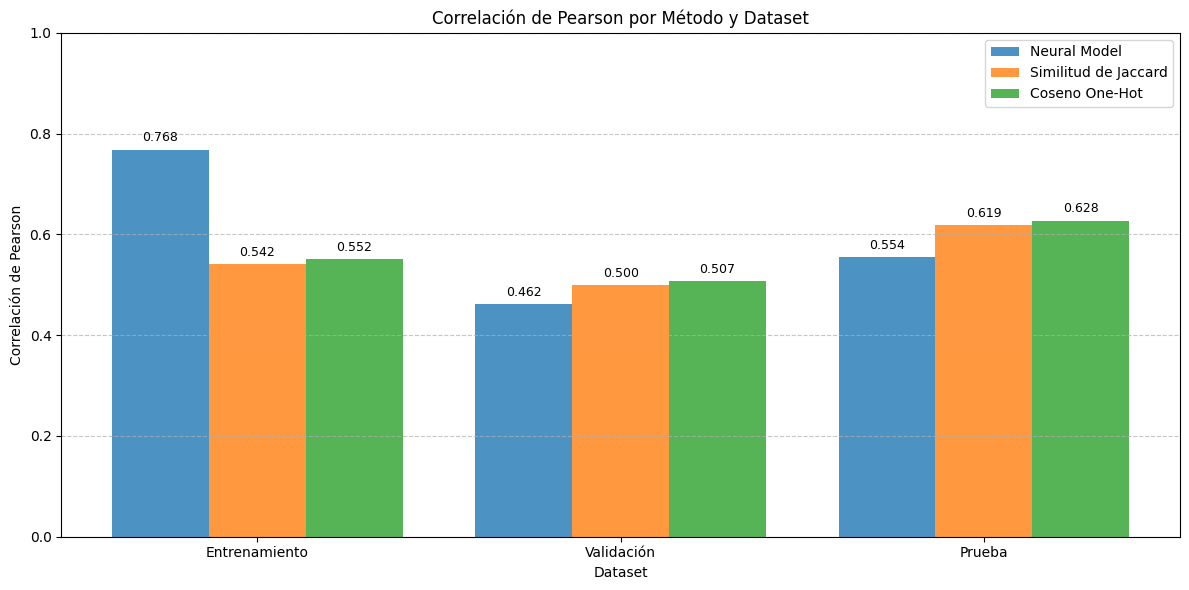

In [20]:
# Almacenar los resultados del método de línea base para la visualización
baseline_methods = {
    'Similitud de Jaccard': {
        'Entrenamiento': train_correlation_jaccard,
        'Validación': val_correlation_jaccard,
        'Prueba': test_correlation_jaccard
    },
    'Coseno One-Hot': {
        'Entrenamiento': train_correlation_cosine,
        'Validación': val_correlation_cosine,
        'Prueba': test_correlation_cosine
    }
}

# Visualizar las correlaciones de Pearson
visualize_pearson_correlations(
    model=model,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    x_test=x_test,
    y_test=y_test,
    baseline_methods=baseline_methods
)

In [21]:
tf.__version__

'2.19.0'

## Experimentación con Embeddings Aleatorios

Para evaluar el impacto de los embeddings preentrenados, se entrena el modelo con embeddings inicializados aleatoriamente. 

**Configuración:**
- `pretrained_weights=None`: Inicialización aleatoria de embeddings
- `trainable_embedding=True`: Los embeddings se actualizan durante el entrenamiento
- Early stopping para prevenir sobreajuste

Este experimento permite cuantificar el valor añadido de los embeddings preentrenados frente al aprendizaje desde cero.

In [22]:
# Construir y compilar el modelo con embeddings aleatorios (sin pretrained_weights)
random_emb_model = build_and_compile_model_2(
    input_length=32,
    dictionary_size=len(diccionario.token2id) + 1,  # +1 para padding
    embedding_size=300,
    pretrained_weights=None,  # Aquí la clave: no utilizamos embeddings preentrenados, se inicializan aleatoriamente
    trainable_embedding=True,  # Los embeddings deben ser entrenables para que el modelo pueda aprender representaciones útiles
    learning_rate=1e-3,
    attention_units=4
)

# Crear un callback para early stopping para evitar sobreentrenamiento
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Entrenar el modelo con los mismos datos pero con embeddings aleatorios
print("Entrenando modelo con embeddings aleatorios...")
history_random = random_emb_model.fit(
    train_dataset,  # Utilizamos el mismo conjunto de entrenamiento que con los embeddings preentrenados
    epochs=num_epochs, 
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

# Evaluar el modelo
random_train_pred = random_emb_model.predict(x_train)
random_val_pred = random_emb_model.predict(x_val)
random_test_pred = random_emb_model.predict(x_test)

random_train_corr, _ = pearsonr(random_train_pred.flatten(), y_train.flatten())
random_val_corr, _ = pearsonr(random_val_pred.flatten(), y_val.flatten())
random_test_corr, _ = pearsonr(random_test_pred.flatten(), y_test.flatten())

print(f"Modelo con embeddings aleatorios - Correlaciones de Pearson:")
print(f"Entrenamiento: {random_train_corr:.4f}")
print(f"Validación: {random_val_corr:.4f}")
print(f"Prueba: {random_test_corr:.4f}")

C:\Users\jiahu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Entrenando modelo con embeddings aleatorios...
Epoch 1/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0690 - mae: 0.2331 - val_loss: 0.0874 - val_mae: 0.2631
Epoch 2/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0351 - mae: 0.1552 - val_loss: 0.0804 - val_mae: 0.2506
Epoch 3/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0135 - mae: 0.0854 - val_loss: 0.0788 - val_mae: 0.2475
Epoch 4/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0074 - mae: 0.0600 - val_loss: 0.0790 - val_mae: 0.2484
Epoch 5/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0055 - mae: 0.0529 - val_loss: 0.0800 - val_mae: 0.2511
Epoch 6/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0051 - mae: 0.0509 - val_loss: 0.0807 - val_mae: 0.2524
Epoch 7/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0051 - mae: 0.0506 - val_loss: 0.0816 - val_mae: 0.2534
Epoch 8/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0048 - mae: 0.0498 - val_loss: 0.0816 - val_mae: 0.2532
Epoch 9/1

## Experimentación con Diferentes Dimensiones de Embeddings

Se evalúa el impacto del tamaño de los embeddings en el rendimiento del modelo mediante la creación de versiones reducidas (50, 100, 150 dimensiones) de los embeddings originales (300 dimensiones).

**Objetivo:** Analizar la relación entre dimensionalidad y capacidad de capturar relaciones semánticas.

In [23]:
# Crear versiones reducidas de los word embeddings
reduced_models = create_reduced_embeddings(wv_model)

# Verificar algunos vectores para confirmar que la reducción funciona
for dim in reduced_models:
    print(f"\nDimensión {dim}:")
    test_word = "casa" if "casa" in wv_model else wv_model.index_to_key[0]
    print(f"Palabra '{test_word}' - Vector: {reduced_models[dim][test_word][:5]}... (forma: {reduced_models[dim][test_word].shape})")

Creando versiones reducidas de los embeddings (2000000 palabras)...
Creando modelo de 50 dimensiones...
Modelo de 50d creado. Ejemplo: 'casa' tiene forma (50,)
Creando modelo de 100 dimensiones...
Modelo de 100d creado. Ejemplo: 'casa' tiene forma (100,)
Creando modelo de 150 dimensiones...
Modelo de 150d creado. Ejemplo: 'casa' tiene forma (150,)
Tiempo total para crear modelos reducidos: 48.57 segundos

Dimensión 50:
Palabra 'casa' - Vector: [-0.0359 -0.0161 -0.0268  0.0022 -0.0873]... (forma: (50,))

Dimensión 100:
Palabra 'casa' - Vector: [-0.0359 -0.0161 -0.0268  0.0022 -0.0873]... (forma: (100,))

Dimensión 150:
Palabra 'casa' - Vector: [-0.0359 -0.0161 -0.0268  0.0022 -0.0873]... (forma: (150,))



Entrenando modelo con embeddings de 50 dimensiones...
Epoch 1/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.1668 - mae: 0.3572 - val_loss: 0.2253 - val_mae: 0.4448
Epoch 2/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1406 - mae: 0.3247 - val_loss: 0.1701 - val_mae: 0.3768
Epoch 3/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0873 - mae: 0.2520 - val_loss: 0.1386 - val_mae: 0.3338
Epoch 4/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0580 - mae: 0.1991 - val_loss: 0.1339 - val_mae: 0.3296
Epoch 5/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0449 - mae: 0.1701 - val_loss: 0.1294 - val_mae: 0.3246
Epoch 6/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0357 - mae: 0.1535 - val_loss: 0.1254 - val_mae: 0.3192
Epoch 7/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0254 - mae: 0.1262 - val_loss: 0.1211 - val_mae: 0.3124
Epoch 8/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0205 - mae: 0.1119 - val_loss: 0.1201 - val_mae: 0.3106
E

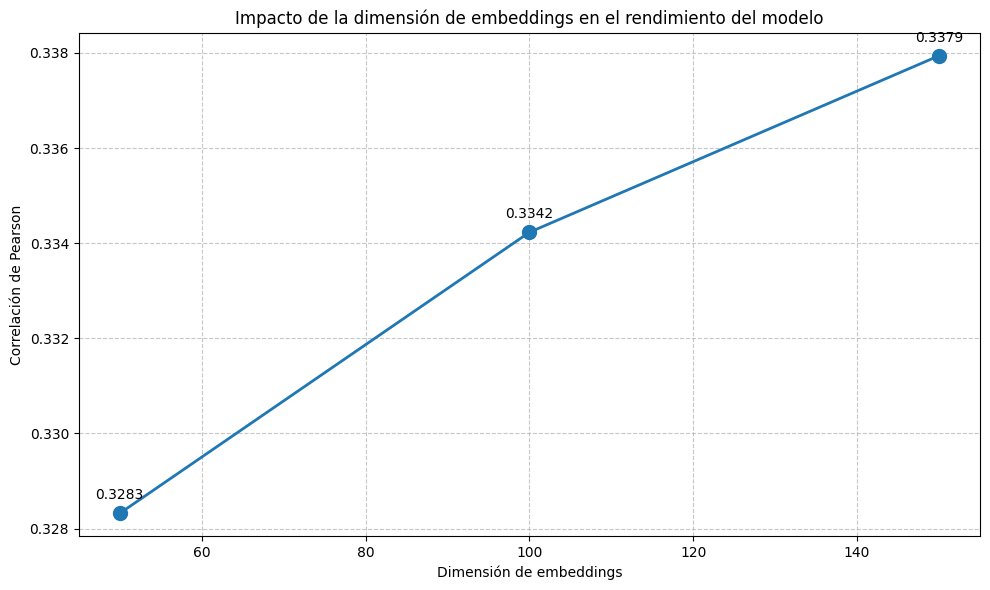

In [24]:
results = build_and_compile_model_with_reduced_embeddings(
    reduced_models, 
    train_dataset, 
    val_dataset, 
    diccionario, 
    num_epochs,
    x_val,
    y_val
)

# Imprimir resumen de resultados
print("\n--- Resumen de resultados por dimensión ---")
for dim in reduced_models:
    print(f"Dimensión {dim}: Correlación de Pearson = {results[dim]:.4f}")

# Crear una visualización para el experimento de dimensión
plt.figure(figsize=(10, 6))
dimensions = list(results.keys())
correlations = [results[dim] for dim in dimensions]

plt.plot(dimensions, correlations, marker='o', linewidth=2, markersize=10)
plt.xlabel('Dimensión de embeddings')
plt.ylabel('Correlación de Pearson')
plt.title('Impacto de la dimensión de embeddings en el rendimiento del modelo')
plt.grid(True, linestyle='--', alpha=0.7)

# Añadir anotaciones de valores
for i, dim in enumerate(dimensions):
    plt.annotate(f'{correlations[i]:.4f}', 
                xy=(dim, correlations[i]), 
                xytext=(0, 10),
                textcoords='offset points',
                ha='center')

plt.tight_layout()
plt.show()

## Análisis Comparativo de Embeddings

**Resultados principales:**

1. **Embeddings aleatorios**: Muestran alto sobreajuste (0.92 en entrenamiento vs 0.52 en validación)
2. **Embeddings preentrenados**: Presentan mejor generalización sin sobreajuste significativo
3. **Dimensionalidad**: Mayor número de dimensiones correlaciona con mejor rendimiento
4. **Conclusión**: Los embeddings preentrenados con dimensiones adecuadas son esenciales para capturar relaciones semánticas efectivas

La inicialización aleatoria requiere regularización adicional para evitar sobreajuste.

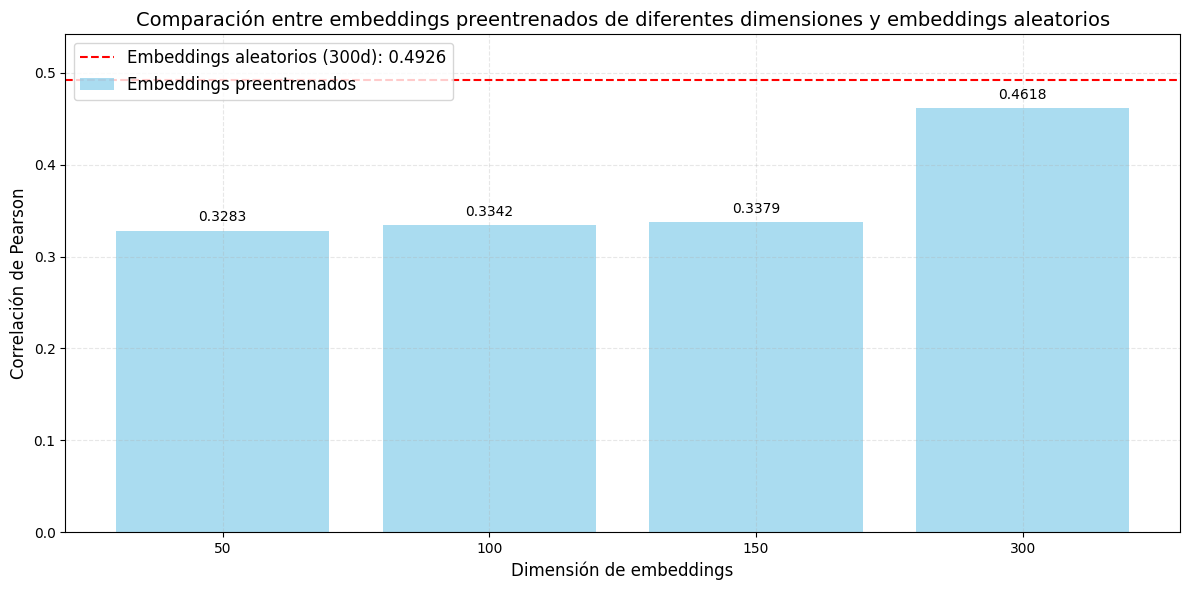

In [25]:
## Grafica de comparativa de correlaciones

# Crear un diccionario con los resultados de correlación de todos los modelos
dimensiones = list(results.keys()) + ['300']  # Añadir dimensión original (300)
correlaciones = []

# Resultados de los modelos con dimensiones reducidas
for dim in results:
    correlaciones.append(results[dim])

# Resultados del modelo original (300d)
correlaciones.append(correlation_val)  # Usar el resultado del modelo base con embeddings completos

# Resultados del modelo con embeddings aleatorios (también 300d)
random_correlacion = random_val_corr  # Usar el resultado del modelo con embeddings aleatorios

# Crear el gráfico de comparación
plt.figure(figsize=(12, 6))

# Convertir dimensiones a números (o a posiciones para el eje x)
x_positions = np.arange(len(dimensiones))

# Gráfico de barras para embeddings de dimensión reducida y original usando posiciones numéricas
barras = plt.bar(x_positions, correlaciones, color='skyblue', alpha=0.7, label='Embeddings preentrenados')

# Línea horizontal para embeddings aleatorios
plt.axhline(y=random_correlacion, color='red', linestyle='--', 
            label=f'Embeddings aleatorios (300d): {random_correlacion:.4f}')

# Añadir etiquetas
plt.xlabel('Dimensión de embeddings', fontsize=12)
plt.ylabel('Correlación de Pearson', fontsize=12)
plt.title('Comparación entre embeddings preentrenados de diferentes dimensiones y embeddings aleatorios', fontsize=14)
plt.xticks(x_positions, dimensiones, fontsize=10)  # Asignar las etiquetas de texto a las posiciones numéricas
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=12)

# Añadir valores sobre las barras
for i, v in enumerate(correlaciones):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=10)

# Mejora visual
plt.ylim(0, max(correlaciones + [random_correlacion]) * 1.1)  # Ajustar el límite superior
plt.tight_layout()

# Mostrar gráfico
plt.show()

## Modelo Mejorado con TF-IDF

Se implementa una variante del modelo de atención que incorpora pesos TF-IDF para mejorar la agregación de embeddings. 

**Hipótesis:** Los pesos TF-IDF pueden ayudar al mecanismo de atención a identificar palabras más discriminativas para la tarea de similitud semántica.

In [26]:
# Construir y entrenar el modelo mejorado con TF-IDF
sentences = sentences_1_preproc + sentences_2_preproc

tfidf_model = build_tfidf_enhanced_model(
    pretrained_weights=pretrained_weights,
    learning_rate=1e-3,
    sentences=sentences,
    dictionary=diccionario if REMAP_EMBEDDINGS else None
)

# Entrenar con early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

tfidf_model.fit(
    train_dataset, 
    epochs=num_epochs, 
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

# Evaluar modelo TF-IDF
tfidf_val_predictions = tfidf_model.predict(x_val)
tfidf_correlation_val, _ = pearsonr(tfidf_val_predictions.flatten(), y_val.flatten())

tfidf_train_predictions = tfidf_model.predict(x_train)
tfidf_correlation_train, _ = pearsonr(tfidf_train_predictions.flatten(), y_train.flatten())

tfidf_test_predictions = tfidf_model.predict(x_test)
tfidf_correlation_test, _ = pearsonr(tfidf_test_predictions.flatten(), y_test.flatten())

print(f"Correlaciones de Pearson del Modelo Mejorado con TF-IDF:")
print(f"Entrenamiento: {tfidf_correlation_train:.4f}")
print(f"Validación: {tfidf_correlation_val:.4f}")
print(f"Prueba: {tfidf_correlation_test:.4f}")



C:\Users\jiahu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1328 - mae: 0.3276 - val_loss: 0.1496 - val_mae: 0.3478
Epoch 2/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0964 - mae: 0.2753 - val_loss: 0.1346 - val_mae: 0.3250
Epoch 3/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0883 - mae: 0.2613 - val_loss: 0.1292 - val_mae: 0.3170
Epoch 4/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0819 - mae: 0.2505 - val_loss: 0.1249 - val_mae: 0.3098
Epoch 5/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0760 - mae: 0.2410 - val_loss: 0.1219 - val_mae: 0.3061
Epoch 6/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0760 - mae: 0.2411 - val_loss: 0.1201 - val_mae: 0.3024
Epoch 7/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0724 - mae: 0.2337 - val_loss: 0.1178 - val_mae: 0.2995
Epoch 8/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0706 - mae: 0.2321 - val_loss: 0.1171 - val_mae: 0.2984
Epoch 9/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - lo

## Modelo Avanzado con Capas LSTM

Se implementa una arquitectura más compleja que incorpora capas LSTM bidireccionales para capturar dependencias secuenciales antes del mecanismo de atención.

**Arquitectura:**
- Embeddings preentrenados
- Capas BiLSTM para modelado secuencial
- Mecanismo de atención
- Capas densas para predicción final

**Objetivo:** Evaluar si el modelado explícito de secuencias mejora la representación de similitud semántica.

In [27]:
# Construir el modelo avanzado BiLSTM
advanced_model = build_simplified_advanced_model(
    pretrained_weights=pretrained_weights,
    learning_rate=5e-4,
    rnn_units=128,
    dropout_rate=0.15
)

# Entrenar con early stopping y reducción de tasa de aprendizaje
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

history = advanced_model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluar el modelo avanzado
adv_train_pred = advanced_model.predict(x_train)
adv_val_pred = advanced_model.predict(x_val)
adv_test_pred = advanced_model.predict(x_test)

adv_train_corr, _ = pearsonr(adv_train_pred.flatten(), y_train.flatten())
adv_val_corr, _ = pearsonr(adv_val_pred.flatten(), y_val.flatten())
adv_test_corr, _ = pearsonr(adv_test_pred.flatten(), y_test.flatten())

print(f"Correlaciones de Pearson del Modelo BiLSTM Avanzado:")
print(f"Entrenamiento: {adv_train_corr:.4f}")
print(f"Validación: {adv_val_corr:.4f}")
print(f"Prueba: {adv_test_corr:.4f}")


Epoch 1/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - loss: 0.0264 - mae: 0.1284 - val_loss: 0.0291 - val_mae: 0.1324 - learning_rate: 5.0000e-04
Epoch 2/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 305ms/step - loss: 0.0288 - mae: 0.1356 - val_loss: 0.0280 - val_mae: 0.1278 - learning_rate: 5.0000e-04
Epoch 3/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - loss: 0.0263 - mae: 0.1276 - val_loss: 0.0272 - val_mae: 0.1264 - learning_rate: 5.0000e-04
Epoch 4/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 250ms/step - loss: 0.0243 - mae: 0.1212 - val_loss: 0.0275 - val_mae: 0.1271 - learning_rate: 5.0000e-04
Epoch 5/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - loss: 0.0243 - mae: 0.1224 - val_loss: 0.0270 - val_mae: 0.1259 - learning_rate: 5.0000e-04
Epoch 6/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 0.0225 - mae: 0.1172 - val_loss: 0.0272 - val_mae: 0.1266 - learning_rate: 5.0000e-04
Epoch 7/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 298ms/step - loss: 0.0207 - mae: 0.1118 - val_loss: 0.0268 - val_mae: 0.1

## Comparación entre los diferentes modelos

Comparando todos los variantes de modelos de regressión junto con la codificación One-Hot, observamos que los modelos de regressión en general aprenden de los datos de train, pero no generalizan bien a los datos de validación o test. La codificación One-Hot, simple y directa, para esta tasca de calcular la similitud funciona bastante bien ya muchas veces la similitud viene dada por las palabras repetidas, pero en otras tascas más complejas seguramente One-Hot Encoding no funcionará tan bien como ha funcionado en esta tasca. Añadiendo una capa de ponderaciones de TF-IDF en la Atención que construye los embedding para cada frase ha ayudado un poco en la prediccion del test, pero no ha mejorado de manera significativa, esto quiere decir que la capa de Atención Simple ya agregaba bien los embeddings. Finalmente, sorprendemente, el modelo de regresión con capas LSTM y atención ha obtenido un rendimiento bastante bajo de lo esperado, dado que no pertence al temario, de momento, no somos capaces de argumentar sus errores, pero en esta tasca de similitud de texto no ha aportado mucha capacidad al modelo.

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


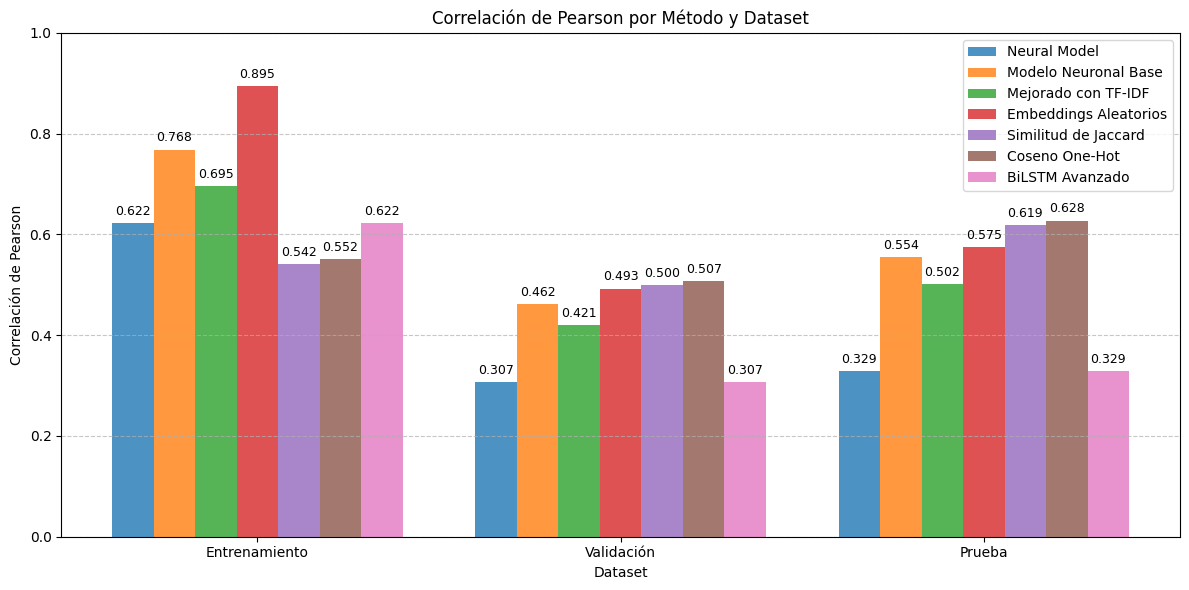

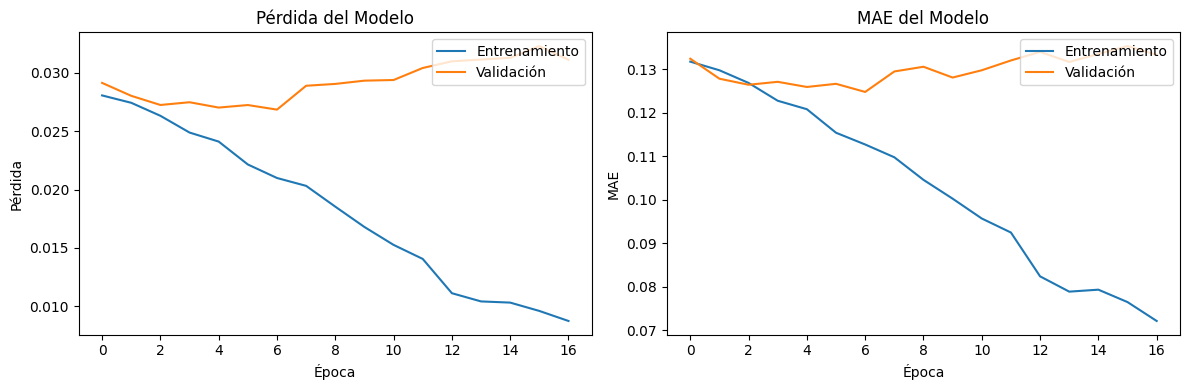

In [28]:
# Comparar modelo TF-IDF con modelo base
methods_comparison = {
    'Modelo Neuronal Base': {
        'Entrenamiento': correlation_train,
        'Validación': correlation_val,
        'Prueba': correlation_test
    },
    'Mejorado con TF-IDF': {
        'Entrenamiento': tfidf_correlation_train,
        'Validación': tfidf_correlation_val,
        'Prueba': tfidf_correlation_test
    },
    'Embeddings Aleatorios': {
        'Entrenamiento': random_train_corr,
        'Validación': random_val_corr,
        'Prueba': random_test_corr
    },
    'Similitud de Jaccard': {
        'Entrenamiento': train_correlation_jaccard,
        'Validación': val_correlation_jaccard,
        'Prueba': test_correlation_jaccard
    },
    'Coseno One-Hot': {
        'Entrenamiento': train_correlation_cosine,
        'Validación': val_correlation_cosine,
        'Prueba': test_correlation_cosine
    }
}


# Actualizar la comparación de métodos para incluir el modelo avanzado
methods_comparison['BiLSTM Avanzado'] = {
    'Entrenamiento': adv_train_corr,
    'Validación': adv_val_corr,
    'Prueba': adv_test_corr
}

# Visualizar la comparación final de todos los métodos
visualize_pearson_correlations(
    model=advanced_model,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    x_test=x_test,
    y_test=y_test,
    baseline_methods=methods_comparison
)

# Visualizar el historial de entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE del Modelo')
plt.ylabel('MAE')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')

plt.tight_layout()
plt.show()

# Conclusión

En resumen, hemos explorado diferentes enfoques para la tarea de similitud entre textos, desde codificaciones simples como One-Hot hasta modelos más complejos con atención y LSTM, también modelos preentrenados como el RoBERTa fine-tuned por STS. Desde un principio, agregando los embeddings mediante medias hasta modelos con Atención, los resultados muestran que, aunque los modelos de regresión con atención pueden capturar relaciones más complejas, la codificación One-Hot sigue siendo una opción competitiva para tareas simples de similitud. La incorporación de TF-IDF en la atención ha mostrado cierta mejora, pero no ha sido decisiva. Finalmente, el uso de LSTM no ha aportado el valor esperado en este contexto específico. 
Finalmente, ninguno de los intentos han podido dar mejores resultados que el modelo preentrenado RoBERTa fine-tuned por STS.